# 목차
> ## 필요한 라이브러리 Import
> ## 이미지 확인
> ## 고화질로 바꿔보기
> ## gif 파일에 적용해보기
> ## 회고

## 필요한 라이브러리 Import

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from glob import glob
from IPython.display import Image as show_gif
import imageio

## 이미지 확인

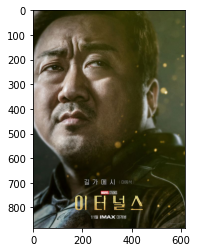

In [2]:
img_path = os.getenv('HOME')+'/aiffel/super_resolution/마동석.jpg'
img = plt.imread(img_path)
plt.imshow(img)
plt.show()

In [3]:
hr = np.array(img)
h, w, d = hr.shape
hr.shape

(883, 616, 3)

* 이미지의 크기를 확인해 보았습니다.

(220, 154, 3)


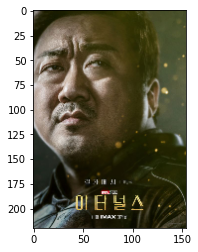

In [4]:
lr = cv2.resize(img, dsize=(w//4,h//4)) # (가로 픽셀 수, 세로 픽셀 수)
print(lr.shape)
plt.imshow(lr)

* 1/4로 줄여서 확인해 보았습니다.

## 고화질로 바꿔보기

In [5]:
bicubic_hr = cv2.resize(lr, dsize = (w, h), interpolation = cv2.INTER_CUBIC)

* bicubic interpolation을 사용해 다시 키워서 비교해보겠습니다.

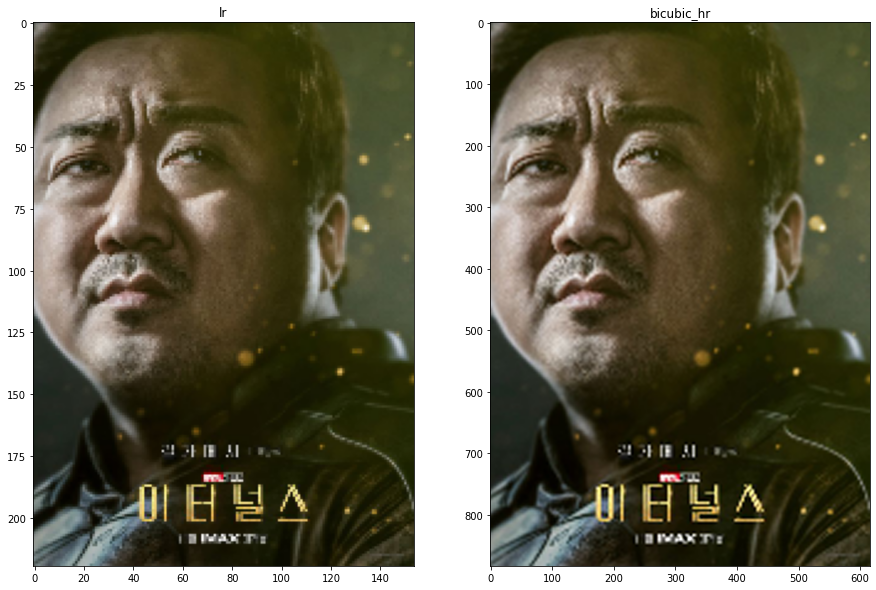

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.title('lr')
plt.imshow(lr)
plt.subplot(1,2,2)
plt.title('bicubic_hr')
plt.imshow(bicubic_hr)
plt.show()

In [7]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

* 전체적으로 보면 그렇게 티가 많이 안나 부분적으로 확인하기 위해 함수를 만들었습니다.

In [8]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

* 이미 학습되어 있는 모델로 SRGAN을 사용해 보겠습니다.

In [9]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [10]:
srgan_hr = apply_srgan(lr)

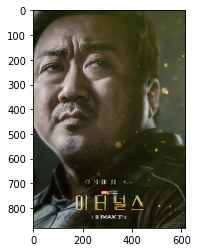

In [11]:
plt.imshow(srgan_hr)
plt.show()

* SRGAN을 사용해서 확인해보았습니다.

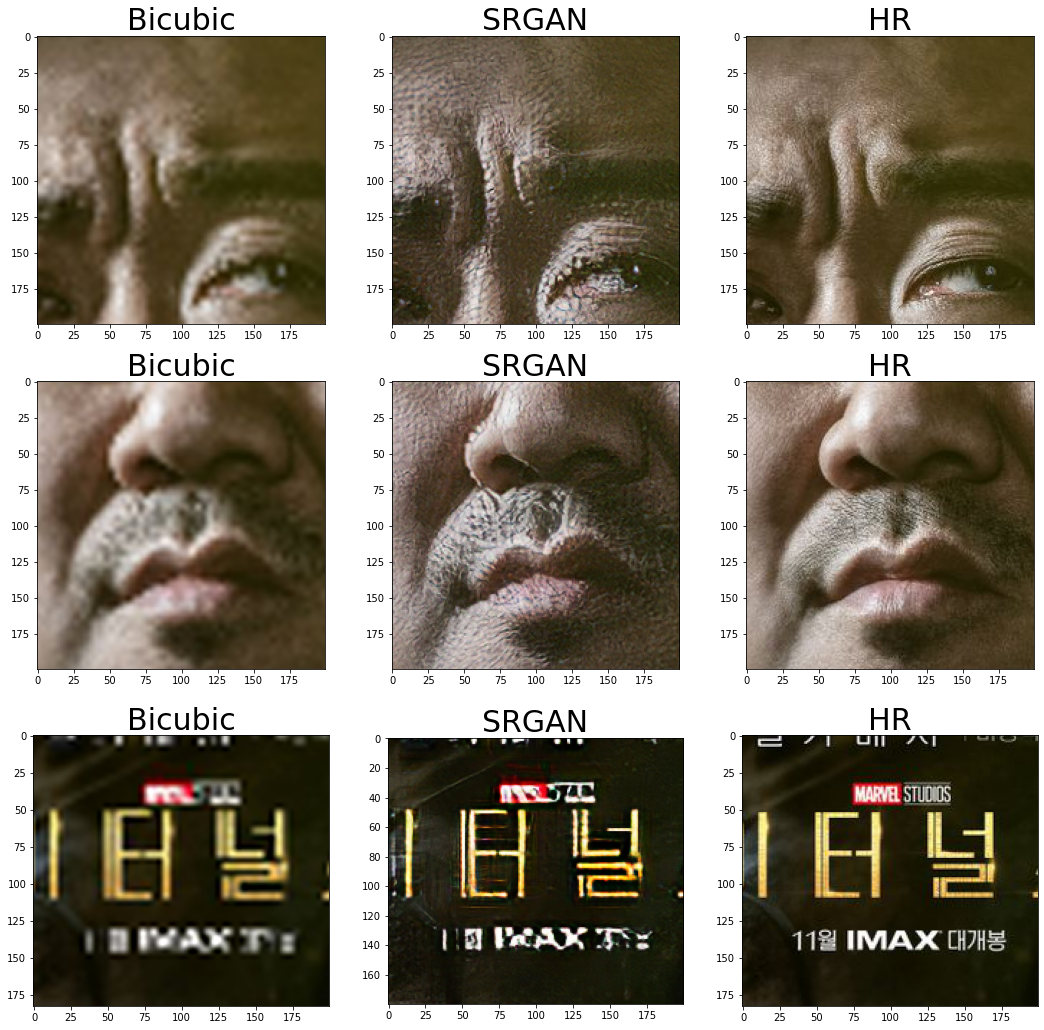

In [12]:
left_tops = [(50,100), (300,50), (700,200)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

* 특정 부분들을 잘라 확인해 보았는데, 역시 원본이 가장 화질이 좋고 그 다음은 SRGAN이 좋다고 생각합니다. 하지만 두 가지 방법 모두 털의 부드러운 부분이나 피부를 매끄럽게 표현하지는 못하였습니다.

(60, 45, 3)


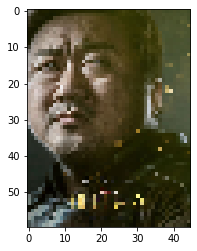

In [13]:
low_img = cv2.resize(img, dsize = (45, 60))
plt.imshow(low_img)
low_lr = np.array(low_img)
print(low_img.shape)
plt.show()

* 아까 사용한 이미지를 일부러 저화질로 리사이즈해서 사용해 보겠습니다.

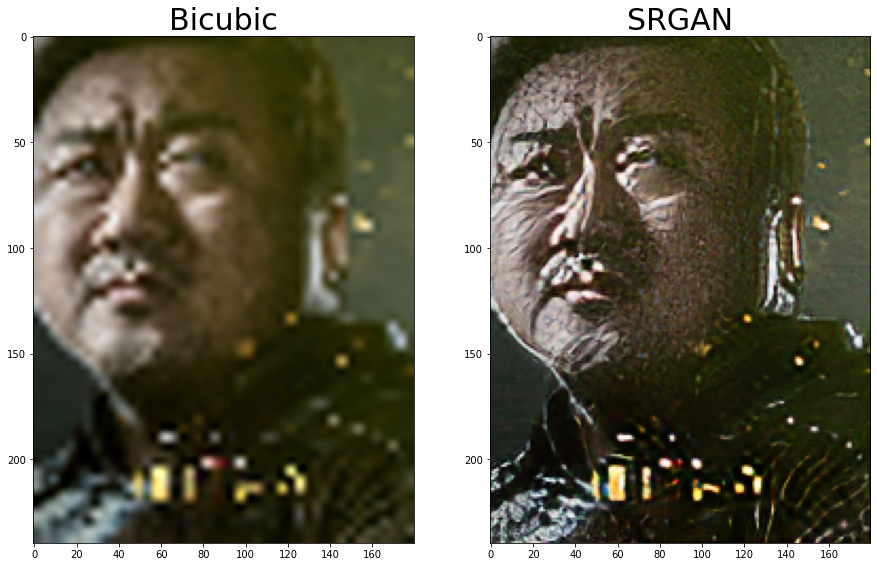

In [14]:
plt.figure(figsize=(15,10))

# SRGAN을 이용해 고해상도로 변환합니다.
srgan_img = apply_srgan(low_lr)

# bicubic interpolation
bicubic_img = cv2.resize(low_lr, (low_lr.shape[1]*4, low_lr.shape[0]*4), interpolation=cv2.INTER_CUBIC)

# 전체 이미지를 시각화합니다.

plt.subplot(121)
plt.title('Bicubic', fontsize=30)
plt.imshow(bicubic_img)

plt.subplot(122)
plt.title('SRGAN', fontsize=30)
plt.imshow(srgan_img)

plt.show()

* 두가지 방법으로 화질을 올려봤는데 이번에도 SRGAN이 더 성능이 좋은것 같습니다.

## gif 파일에 적용해보기

In [15]:
gif = cv2.VideoCapture("/aiffel/aiffel/super_resolution/city_night_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


* gif 파일을 프레임단위로 잘라 이미지로 리스트에 저장했습니다. 총 8장이네요.

In [16]:
frames_sr = []
for lr in frames:
    bicubic_hr = cv2.resize(lr, dsize = (500*4, 255*4), interpolation = cv2.INTER_CUBIC)
    frames_sr.append(bicubic_hr)

* 각각의 이미지를 bicubic interpolation를 사용해 새로운 리스트에 저장했습니다.

In [17]:
frames_sr_2 = []
for lr in frames:
    srgan_img = apply_srgan(lr)
    frames_sr_2.append(srgan_img)

* 각각의 이미지를 SRGAN을 사용해서 새로운 리스트에 저장했습니다.

In [18]:
imageio.mimsave("Bicubic_interpolation.gif", frames_sr)

* bicubic interpolation로 변환된 사진들을 gif 파일로 저장했습니다.

In [19]:
imageio.mimsave("SRGAN.gif", frames_sr_2)

* SRGAN으로 변환된 사진들을 gif 파일로 저장했습니다.

### 원본 gif

In [1]:
#show_gif("/aiffel/aiffel/super_resolution/city_night_lr.gif", width=800)

![city_night_lr](https://user-images.githubusercontent.com/84653776/143381172-ab14ed6b-563e-4899-a833-eac236f3d729.gif)

### bicubic interpolation gif

In [2]:
#show_gif("/aiffel/aiffel/Bicubic_interpolation.gif", width=800)

![Bicubic_interpolation](https://user-images.githubusercontent.com/84653776/143381761-afcc3978-0b96-4b37-9be1-9448e2f420a0.gif)

### SRGAN gif

In [3]:
#show_gif("/aiffel/aiffel/SRGAN.gif", width=800)

![SRGAN](https://user-images.githubusercontent.com/84653776/143381800-e0218b26-3add-4773-9aee-41a73ed133a0.gif)

* 두가지 방법 모두 멀리서 보면 크게 바뀌지 않지만 확대해서 보니 이번에도 SRGAN의 성능이 좋았습니다.

## 회고
* 예전에 컴퓨터의 안경은 없을까? 생각을 해보았는데 이런 방법이 있구나 알아가는것 같습니다.
* 기본화질이 낮으면 아무리 화질을 높여도 안된다는 글을 읽은적이 있는데, 확실히 적용해 보니 사람 얼굴은 어느정도 구분 가능하지만 글자는 거의 확인이 불가능한것 같습니다.